# Bibliotecas

In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.repair import Repair
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.termination import get_termination
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from multiprocessing import Pool
from functools import partial

# Configurações

In [ ]:
start_date = '2023-01-01'
end_date = '2023-12-31'

max_weight = 0.10
pop_size = 250

initial_value = 100000

# Dados

In [109]:
close_price_df = pd.read_csv('relatorios/preco-ativos.csv', index_col=0, parse_dates=True)
daily_return_df = np.log(close_price_df / close_price_df.shift(1)).dropna()
filtered_df = daily_return_df[start_date:end_date]

selic_df = pd.read_csv("baselines/SELIC.csv", sep=";", parse_dates=["Date"], dayfirst=True, index_col='Date')
selic_df = selic_df[start_date:end_date]

last_day_months = (filtered_df.groupby(filtered_df.index.to_period('M')).tail(1)).index
first_day_year = pd.Index([filtered_df.index[0]])
portfolio_dates = first_day_year.append(last_day_months)
rebalance_dates = portfolio_dates[:-1]

# Modelo

In [110]:
class PortfolioProblem(ElementwiseProblem):
    def __init__(self, mu, cov, max_weight=0.10, **kwargs):
        self.n_assets = len(mu)
        self.max_weight = max_weight

        super().__init__(n_var=self.n_assets, n_obj=2, n_constr=self.n_assets, xl=0.0, xu=1.0, **kwargs)
        self.mu = mu
        self.cov = cov

    def _evaluate(self, x, out, *args, **kwargs):
        expected_return = self.mu.T @ x
        risk = x.T @ self.cov @ x
        out["F"] = [risk, -expected_return]

        g1 = x - self.max_weight
        out["G"] = g1

class SumToOneRepair(Repair):
    def _do(self, problem, X, **kwargs):
        return X / np.sum(X, axis=1, keepdims=True)

# Otimização

In [111]:
def portfolio_optimize(daily_return_df, rebalance_dates, max_weight, pop_size):
    pareto_fronts = []
    pareto_weights = []

    for i in range(len(rebalance_dates)):
        period_start = rebalance_dates[i]
        log_returns = daily_return_df.loc[:period_start].iloc[-252:]
        if log_returns.empty:
            continue
        mu = log_returns.mean() * 252
        cov = log_returns.cov() * 252

        problem = PortfolioProblem(mu, cov, max_weight)
        algorithm = NSGA2(pop_size=pop_size,
                          repair=SumToOneRepair(),
                          crossover=SBX(prob=0.9, eta=20.0),
                          mutation=PM(prob=1.0 / problem.n_var,eta=20.0))
        termination = get_termination("n_gen", 500)
        res = minimize(problem,
                       algorithm,
                       termination,
                       seed=1,
                       verbose=False)

        pareto_fronts.append(res.F)
        pareto_weights.append(res.X)

    return pareto_fronts, pareto_weights

In [112]:
pareto_fronts, pareto_weights = portfolio_optimize(daily_return_df, rebalance_dates, max_weight, pop_size)
print(len(pareto_fronts))

12


# BACKTEST

## Maior sharpe

In [113]:
def get_all_max_sharpe_portfolios(pareto_weights, pareto_fronts, rebalance_dates, selic_df):
    all_weights = []
    all_sharpe_ratios = []
    valid_dates = []
    
    for i in range(len(pareto_fronts)):
        date = rebalance_dates[i]
        
        if date in selic_df.index:
            risk_free_rate = selic_df.loc[date, 'Taxa'] / 100
        else:
            available_dates = selic_df.index[selic_df.index <= date]
            if len(available_dates) > 0:
                closest_date = available_dates[-1]
                risk_free_rate = selic_df.loc[closest_date, 'Taxa'] / 100
            else:
                risk_free_rate = 0.02
        
        # Calcular Sharpe Ratios para todas as soluções desta frente
        front = pareto_fronts[i]
        weights = pareto_weights[i]
        
        # Front: [risco, -retorno]
        expected_returns = -front[:, 1]  # Inverter sinal do retorno
        risks = np.sqrt(front[:, 0])     # Volatilidade (raiz da variância)
        
        # Calcular Sharpe Ratio
        sharpe_ratios = (expected_returns - risk_free_rate) / np.sqrt(risks)
        
        # Encontrar índice do maior Sharpe Ratio
        max_sharpe_idx = np.argmax(sharpe_ratios)
        
        # Armazenar resultados
        best_weights = weights[max_sharpe_idx]
        best_sharpe = sharpe_ratios[max_sharpe_idx]
        
        all_weights.append(best_weights)
        all_sharpe_ratios.append(best_sharpe)
        valid_dates.append(date)
        
        print(f"Data: {date.strftime('%Y-%m-%d')} | Sharpe: {best_sharpe:.4f} | Risk-free: {risk_free_rate:.4f}")
    
    return all_weights, all_sharpe_ratios, valid_dates

all_weights, all_sharpe_ratios, valid_dates = get_all_max_sharpe_portfolios(
    pareto_weights, pareto_fronts, rebalance_dates, selic_df
)

print(f"\nNúmero de portfólios otimizados: {len(all_weights)}")
print(f"Sharpe Ratio médio: {np.mean(all_sharpe_ratios):.4f}")
print(f"Melhor Sharpe Ratio: {np.max(all_sharpe_ratios):.4f}")

Data: 2023-01-02 | Sharpe: 0.1957 | Risk-free: 0.1365
Data: 2023-01-31 | Sharpe: 0.2785 | Risk-free: 0.1365
Data: 2023-02-28 | Sharpe: 0.1114 | Risk-free: 0.1365
Data: 2023-03-31 | Sharpe: 0.0310 | Risk-free: 0.1365
Data: 2023-04-28 | Sharpe: 0.1662 | Risk-free: 0.1365
Data: 2023-05-31 | Sharpe: 0.1973 | Risk-free: 0.1365
Data: 2023-06-30 | Sharpe: 0.5289 | Risk-free: 0.1365
Data: 2023-07-31 | Sharpe: 0.5862 | Risk-free: 0.1365
Data: 2023-08-31 | Sharpe: 0.3294 | Risk-free: 0.1315
Data: 2023-09-29 | Sharpe: 0.4006 | Risk-free: 0.1265
Data: 2023-10-31 | Sharpe: 0.3423 | Risk-free: 0.1265
Data: 2023-11-30 | Sharpe: 0.7262 | Risk-free: 0.1215

Número de portfólios otimizados: 12
Sharpe Ratio médio: 0.3245
Melhor Sharpe Ratio: 0.7262


## Backtest

In [114]:
def backtest_and_plot(all_weights, portfolio_dates, close_price_df, initial_value=100000):
    portfolio_values = [initial_value]
    portfolio_value = initial_value
    
    print("=== BACKTEST ===")
    
    for i in range(len(all_weights)):
        current_date = portfolio_dates[i]
        next_date = portfolio_dates[i+1]
        weights = all_weights[i]
        
        # Calcular retorno do período
        current_prices = close_price_df.loc[current_date]
        next_prices = close_price_df.loc[next_date]
        
        # Retorno simples dos ativos
        asset_returns = (next_prices / current_prices) - 1
        
        # Retorno do portfólio
        portfolio_return = np.sum(weights * asset_returns)
        
        # Atualizar valor do portfólio
        portfolio_value *= (1 + portfolio_return)
        portfolio_values.append(portfolio_value)
        
        print(f"{current_date.strftime('%Y-%m-%d')} -> {next_date.strftime('%Y-%m-%d')}: {portfolio_return:.2%}")
    
    return portfolio_values

portfolio_values = backtest_and_plot(all_weights, portfolio_dates, close_price_df, initial_value)

=== BACKTEST ===
2023-01-02 -> 2023-01-31: 5.49%
2023-01-31 -> 2023-02-28: -4.45%
2023-02-28 -> 2023-03-31: -1.19%
2023-03-31 -> 2023-04-28: 2.37%
2023-04-28 -> 2023-05-31: 0.88%
2023-05-31 -> 2023-06-30: 2.27%
2023-06-30 -> 2023-07-31: 3.50%
2023-07-31 -> 2023-08-31: -3.51%
2023-08-31 -> 2023-09-29: -1.08%
2023-09-29 -> 2023-10-31: 2.80%
2023-10-31 -> 2023-11-30: 5.11%
2023-11-30 -> 2023-12-28: 4.90%


# Análise dos resultados

## Evolução do portfólio ao longo do tempo

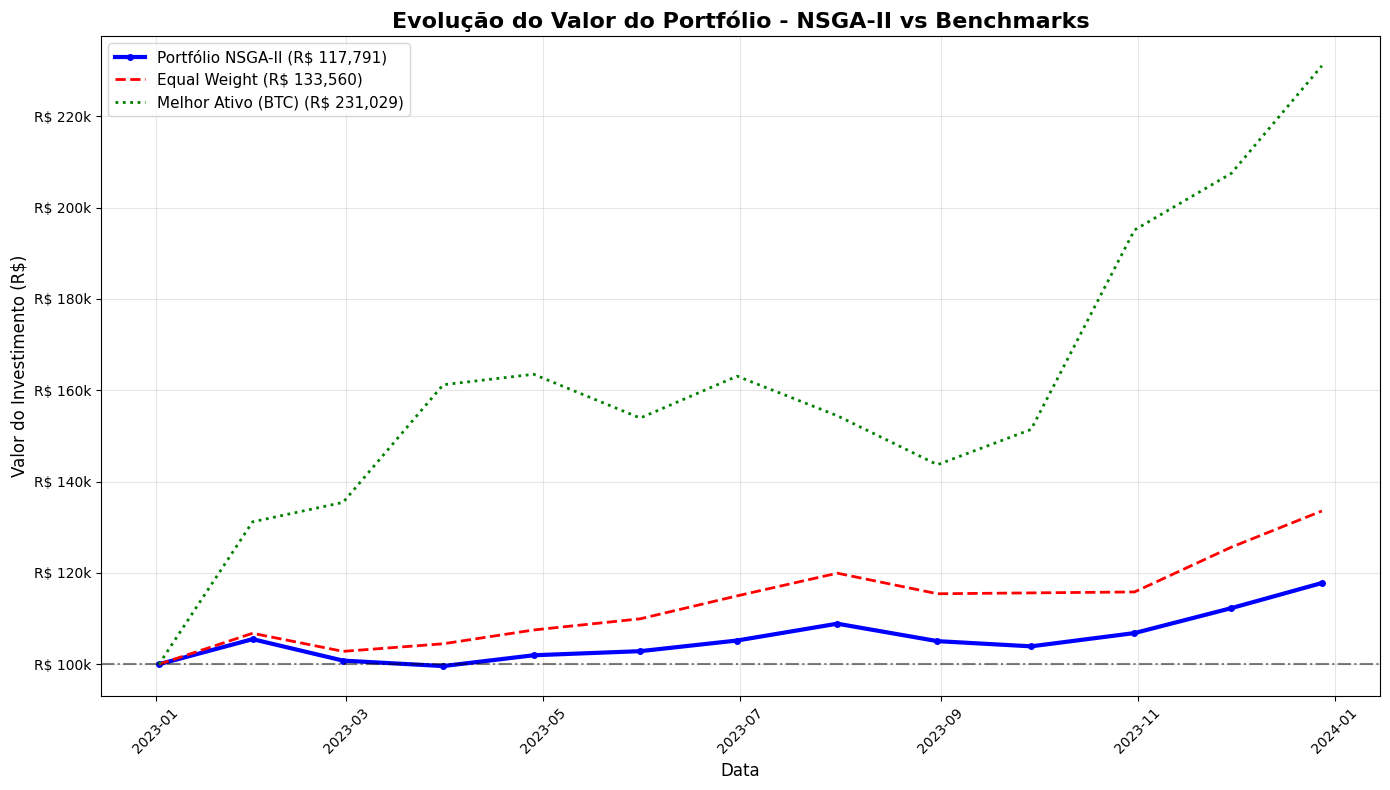


=== RESULTADOS COMPARATIVOS ===
NSGA-II:      R$ 117,791.28 ( 17.79%)
Equal Weight: R$ 133,559.98 ( 33.56%)
Melhor Ativo: R$ 231,029.22 (131.03%)


In [115]:
def plot_portfolio_evolution(portfolio_values, portfolio_dates, close_price_df, start_date, end_date):
    """Plota a evolução do portfólio vs benchmarks"""
    
    # Criar figura
    plt.figure(figsize=(14, 8))
    
    # 1. Portfólio NSGA-II
    plt.plot(portfolio_dates, portfolio_values, 
             linewidth=3, label=f'Portfólio NSGA-II (R$ {portfolio_values[-1]:,.0f})', 
             color='blue', marker='o', markersize=4)
    
    # 2. Buy & Hold igual peso (benchmark)
    equal_weight_values = []
    equal_weight_dates = portfolio_dates.copy()
    initial_value = portfolio_values[0]
    
    # Calcular performance de equal weight
    num_assets = len(close_price_df.columns)
    equal_weights = np.ones(num_assets) / num_assets
    
    equal_weight_value = initial_value
    equal_weight_values.append(equal_weight_value)
    
    for i in range(len(portfolio_dates)-1):
        current_date = portfolio_dates[i]
        next_date = portfolio_dates[i+1]
        
        current_prices = close_price_df.loc[current_date]
        next_prices = close_price_df.loc[next_date]
        asset_returns = (next_prices / current_prices) - 1
        
        portfolio_return = np.sum(equal_weights * asset_returns)
        equal_weight_value *= (1 + portfolio_return)
        equal_weight_values.append(equal_weight_value)
    
    plt.plot(equal_weight_dates, equal_weight_values, 
             linewidth=2, label=f'Equal Weight (R$ {equal_weight_values[-1]:,.0f})', 
             color='red', linestyle='--')
    
    # 3. Benchmark individual (melhor ativo)
    best_asset_performance = {}
    for col in close_price_df.columns:
        start_price = close_price_df.loc[portfolio_dates[0], col]
        end_price = close_price_df.loc[portfolio_dates[-1], col]
        performance = (end_price / start_price) * initial_value
        best_asset_performance[col] = performance
    
    best_asset = max(best_asset_performance, key=best_asset_performance.get)
    best_asset_value = best_asset_performance[best_asset]
    
    # Calcular evolução do melhor ativo
    best_asset_values = []
    for date in portfolio_dates:
        price_ratio = close_price_df.loc[date, best_asset] / close_price_df.loc[portfolio_dates[0], best_asset]
        best_asset_values.append(initial_value * price_ratio)
    
    plt.plot(portfolio_dates, best_asset_values, 
             linewidth=2, label=f'Melhor Ativo ({best_asset}) (R$ {best_asset_value:,.0f})', 
             color='green', linestyle=':')
    
    # Formatação do gráfico
    plt.title('Evolução do Valor do Portfólio - NSGA-II vs Benchmarks', fontsize=16, fontweight='bold')
    plt.xlabel('Data', fontsize=12)
    plt.ylabel('Valor do Investimento (R$)', fontsize=12)
    
    # Formatação do eixo Y
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'R$ {x/1000:.0f}k'))
    
    # Formatação do eixo X
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    plt.xticks(rotation=45)
    
    # Grid e legenda
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11, loc='upper left')
    
    # Linha de referência do valor inicial
    plt.axhline(y=initial_value, color='black', linestyle='-.', alpha=0.5, 
                label=f'Valor Inicial (R$ {initial_value:,.0f})')
    
    plt.tight_layout()
    plt.show()
    
    # Métricas de performance
    total_return_nsga = (portfolio_values[-1] / portfolio_values[0]) - 1
    total_return_equal = (equal_weight_values[-1] / equal_weight_values[0]) - 1
    total_return_best = (best_asset_values[-1] / best_asset_values[0]) - 1
    
    print("\n=== RESULTADOS COMPARATIVOS ===")
    print(f"NSGA-II:      R$ {portfolio_values[-1]:>10,.2f} ({total_return_nsga:>7.2%})")
    print(f"Equal Weight: R$ {equal_weight_values[-1]:>10,.2f} ({total_return_equal:>7.2%})")
    print(f"Melhor Ativo: R$ {best_asset_values[-1]:>10,.2f} ({total_return_best:>7.2%})")
    
    return portfolio_values, equal_weight_values, best_asset_values

# Executar plotagem
portfolio_vals, equal_vals, best_vals = plot_portfolio_evolution(
    portfolio_values, portfolio_dates, close_price_df, start_date, end_date
)

## Composição do portfólio ao longo do tempo

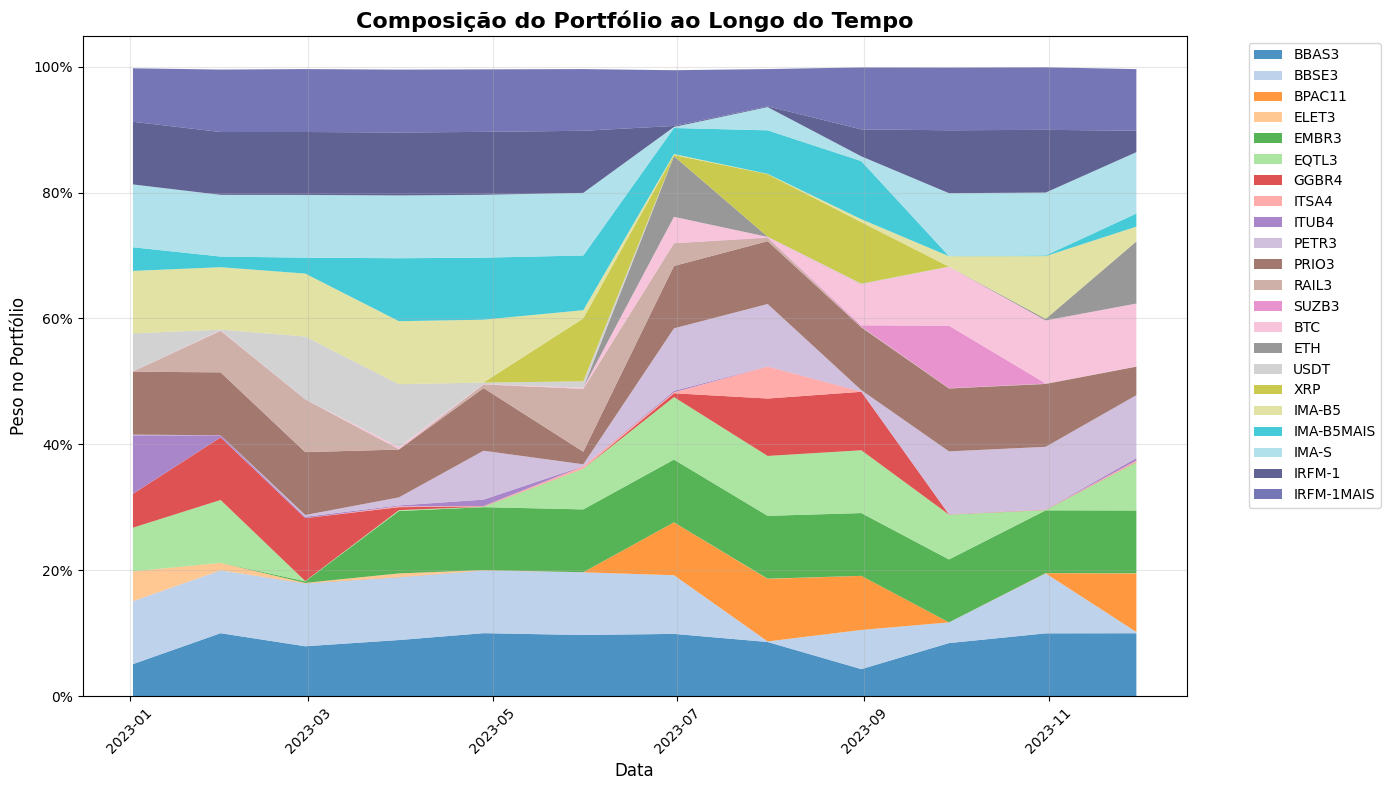


=== TOP 10 ATIVOS POR PESO MÉDIO ===
IRFM-1MAIS: 9.4%
PRIO3: 8.7%
BBAS3: 8.6%
IMA-S: 7.8%
EMBR3: 7.5%
BBSE3: 7.4%
IRFM-1: 7.3%
EQTL3: 5.7%
IMA-B5: 5.5%
PETR3: 5.0%


In [116]:
# Análise adicional: Composição do portfólio ao longo do tempo
def plot_portfolio_composition(all_weights, rebalance_dates, close_price_df):
    """Plota a composição do portfólio ao longo do tempo"""
    
    # Criar DataFrame com os pesos
    tickers = close_price_df.columns.tolist()
    weights_df = pd.DataFrame(all_weights, columns=tickers, index=rebalance_dates[:len(all_weights)])
    
    # Mostrar apenas ativos com peso médio > 1%
    avg_weights = weights_df.mean()
    significant_assets = avg_weights[avg_weights > 0.001].index
    
    # Plot stacked area
    plt.figure(figsize=(14, 8))
    
    # Definindo o número de ativos
    num_assets = len(significant_assets)
    
    # Combinando as paletas tab20 e tab20b
    colors1 = plt.cm.tab20(np.linspace(0, 1, 20))
    colors2 = plt.cm.tab20b(np.linspace(0, 1, 20))
    all_combined_colors = np.vstack((colors1, colors2))
    
    # Seleciona apenas o número de cores necessário
    colors = all_combined_colors[:num_assets]
    
    weights_significant = weights_df[significant_assets]
    
    plt.stackplot(weights_df.index, 
                  *[weights_significant[col] for col in significant_assets],
                  labels=significant_assets,
                  colors=colors,
                  alpha=0.8)
    
    plt.title('Composição do Portfólio ao Longo do Tempo', fontsize=16, fontweight='bold')
    plt.xlabel('Data', fontsize=12)
    plt.ylabel('Peso no Portfólio', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0%}'))
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Estatísticas dos pesos
    print("\n=== TOP 10 ATIVOS POR PESO MÉDIO ===")
    top_assets = avg_weights.sort_values(ascending=False).head(10)
    for asset, weight in top_assets.items():
        print(f"{asset}: {weight:.1%}")

# Plotar composição
plot_portfolio_composition(all_weights, rebalance_dates, close_price_df)